In [1]:
!pip install --q seaborn

ERROR: tensorflow 2.13.1 has requirement numpy<=1.24.3,>=1.22, but you'll have numpy 1.24.4 which is incompatible.
ERROR: snowflake-ml-python 1.0.1 has requirement absl-py<2,>=0.15, but you'll have absl-py 2.1.0 which is incompatible.
ERROR: snowflake-ml-python 1.0.1 has requirement packaging<24,>=20.9, but you'll have packaging 24.0 which is incompatible.
ERROR: snowflake-ml-python 1.0.1 has requirement pandas<2,>=1.0.0, but you'll have pandas 2.0.3 which is incompatible.
ERROR: snowflake-ml-python 1.0.1 has requirement snowflake-snowpark-python<2,>=1.4.0, but you'll have snowflake-snowpark-python 1.0.0 which is incompatible.
ERROR: snowflake-connector-python 3.6.0 has requirement urllib3<2.0.0,>=1.21.1; python_version < "3.10", but you'll have urllib3 2.2.1 which is incompatible.
ERROR: openapi-spec-validator 0.7.1 has requirement jsonschema<5.0.0,>=4.18.0, but you'll have jsonschema 3.2.0 which is incompatible.
ERROR: openapi-schema-validator 0.6.2 has requirement jsonschema<5.0.0,>

In [2]:
!pip install --q xgboost

ERROR: tensorflow 2.13.1 has requirement numpy<=1.24.3,>=1.22, but you'll have numpy 1.24.4 which is incompatible.
ERROR: snowflake-ml-python 1.0.1 has requirement absl-py<2,>=0.15, but you'll have absl-py 2.1.0 which is incompatible.
ERROR: snowflake-ml-python 1.0.1 has requirement packaging<24,>=20.9, but you'll have packaging 24.0 which is incompatible.
ERROR: snowflake-ml-python 1.0.1 has requirement pandas<2,>=1.0.0, but you'll have pandas 2.0.3 which is incompatible.
ERROR: snowflake-ml-python 1.0.1 has requirement snowflake-snowpark-python<2,>=1.4.0, but you'll have snowflake-snowpark-python 1.0.0 which is incompatible.
ERROR: snowflake-ml-python 1.0.1 has requirement xgboost<2,>=1.7.3, but you'll have xgboost 2.0.3 which is incompatible.
ERROR: mosaic-ai-serving 1.0.0 has requirement Flask==2.1.1; python_version >= "3.7", but you'll have flask 2.2.5 which is incompatible.
ERROR: mosaic-ai-serving 1.0.0 has requirement matplotlib==3.6.0; python_version >= "3.8", but you'll have 

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from numpy.random import randint
from multiprocessing import cpu_count
import os
import warnings
warnings.filterwarnings('ignore')

from snowflake.snowpark import Session
import configparser

Matplotlib created a temporary cache directory at /tmp/matplotlib-jwbdtrrm because the default path (/home/mosaic-ai/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [3]:
from sklearn.linear_model import LogisticRegression ,SGDClassifier
from sklearn.preprocessing import FunctionTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline #pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE #for feature selection
#from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler,LabelEncoder
from sklearn.metrics import (f1_score,classification_report,
                             roc_auc_score,confusion_matrix,roc_curve,auc) # evaluatin metrics
from sklearn.model_selection import KFold,RandomizedSearchCV ,cross_val_score,RepeatedStratifiedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB 
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier ,RandomForestClassifier
from xgboost import XGBClassifier
import gc

### Code to establish connection and read data from Snowflake

In [4]:
config = configparser.ConfigParser()
config.read("snowflake_connection.ini")

['snowflake_connection.ini']

In [5]:
connection_parameters = {
    "user": f'{config["Snowflake"]["user"]}',
    "password": f'{config["Snowflake"]["password"]}',
    #"password": os.getenv('snowflake_password'),
    "account": f'{config["Snowflake"]["account"]}',
    #"account": os.getenv('snowflake_account'),
    "WAREHOUSE": f'{config["Snowflake"]["WAREHOUSE"]}',
    "DATABASE": f'{config["Snowflake"]["DATABASE"]}',
    "SCHEMA": f'{config["Snowflake"]["SCHEMA"]}'
}

In [6]:
def snowflake_connector(conn):
    try:
        session = Session.builder.configs(conn).create()
        print("connection successful!")
    except:
        raise ValueError("error while connecting with db")
    return session

session = snowflake_connector(connection_parameters)

connection successful!


In [7]:
application_train_sf  = session.table("CRA_APPLICATION_TRAIN_DETAILS")
application_test_sf  = session.table("CRA_APPLICATION_TEST_DETAILS")

In [8]:
application_train = application_train_sf.to_pandas()

In [9]:
application_test = application_test_sf.to_pandas()

In [10]:
pd.set_option('display.max_rows', 30)
def info(table):
    print(f'\n the shape of the table is : \n',table.shape)
    print('-' * 80)
    print('\n data types : ', table.dtypes.value_counts().sort_values())
    print('-' * 80)
    missings=table.isna().mean()[table.isna().mean().sort_values(ascending=False)!=0].sort_values(ascending=False)
    print('-' * 80)
    print('\n number of features having missing data : ',len(missings))
    print('-' * 80)
    print('\n missing data in the table: \n',missings)
    print('-' * 80)
    print(missings[missings>0.5])
    print('-' * 80)
    print('\n missing data over 50% : ',len(missings[missings>0.5]))
info(application_train)


 the shape of the table is : 
 (307511, 124)
--------------------------------------------------------------------------------

 data types :  datetime64[ns]     1
int32              2
int16              2
object            17
int8              37
float64           65
Name: count, dtype: int64
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------

 number of features having missing data :  61
--------------------------------------------------------------------------------

 missing data in the table: 
 COMMONAREA_MODE             0.698723
COMMONAREA_MEDI             0.698723
COMMONAREA_AVG              0.698723
NONLIVINGAPARTMENTS_MODE    0.694330
NONLIVINGAPARTMENTS_AVG     0.694330
                              ...   
EXT_SOURCE_2                0.002146
AMT_GOODS_PRICE             0.000904
AMT_ANNUITY                 0.000039
CNT_FAM_MEMBERS             0.000007
DAYS_LAST_PHON

The data we are working with contains307511 observations and 122 columns only 16 of them are categorical and the rest are numeric .
But the problem we are facing here is the huge amout of missing data with 67 columns contains missing informations with proportion more than 60% exceed threshold of 50% of missingness .
To tackle this problem we should do further analysis and select best strategies to handle them ,so let's start with the analysis first and keep this task to the processing step.

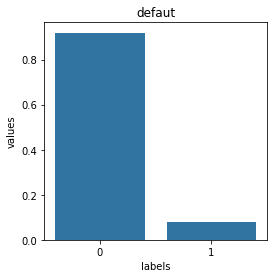

In [11]:
temp = application_train.TARGET.value_counts()
df1 = pd.DataFrame({'labels': temp.index,
                   'values': temp.values/len(application_train)})
plt.figure(figsize = (4,4))
plt.title('defaut')
sns.set_color_codes("pastel")
sns.barplot(x = 'labels', y="values", data=df1)
locs, labels = plt.xticks()
plt.show()

From the distribution plot of the TARGET column we notice than our data suffers from imbalanced classes , There are far more loans that were repaid on time than loans that were not repaid.This may affect the model and results in biased predictions toward the non default class.It's important to choose the right option to handle this issue before running model.

In [12]:
NUMERIC_FEATURES = application_train.select_dtypes(['int8','int16','float16','int32','float32','int64','float64']).columns

In [13]:
application_train[NUMERIC_FEATURES].describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,...,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,...,0.089798,0.024387,0.022518,0.018299,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


From this dataframe numeric features are not well identified and contains categorical features representent as numerical ones and these are :

SK_ID_CURR is an index not feature.
TARGET ,children represents the number of children the applicant have.
FLAG_DOCUMENT_2, FLAG_DOCUMENT_3, .... FLAG_DOCUMENT_20 ,FLAG_DOCUMENT_21 :These features are binary flags indicating the presence or absence of specific documents in the applicant's file. Each flag represents a different type of document (e.g., identification documents, income documents, etc.)

another finding is that the group :
AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON, AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR represent the number of inquiries or requests made to the Credit Bureau by the applicant within specific time intervals. Each feature corresponds to a different time unit (hour, day, week, month, quarter, year).

In [14]:
EXT_SOURCE_TARGET=['EXT_SOURCE_1','EXT_SOURCE_2', 'EXT_SOURCE_3','TARGET']
application_train[EXT_SOURCE_TARGET].corr().style.format("{:.4}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1)

,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,TARGET
EXT_SOURCE_1,1.0,0.214,0.1868,-0.1553
EXT_SOURCE_2,0.214,1.0,0.1092,-0.1605
EXT_SOURCE_3,0.1868,0.1092,1.0,-0.1789
TARGET,-0.1553,-0.1605,-0.1789,1.0


EXT_SOURCE features have small correlation between each other and they have small negative correlatons with the target .

In [15]:
def t_test(df):
    t_stat_list=[]
    p_val_list=[]
    variable=[]

    for var in df.columns:    
        t_stat, p_val = stats.ttest_ind(application_train[application_train['TARGET'] == 0][var],
                                        application_train[application_train['TARGET'] == 1][var])
        if p_val < 0.05:
            variable.append(var)
            t_stat_list.append(t_stat)
            p_val_list.append(p_val)

    t_test = pd.DataFrame({'variable': variable, 't_stat': t_stat_list, 'p_val': p_val_list})
    return t_test.sort_values(by='p_val',ascending=True)

In [16]:
t_test(application_train.select_dtypes(['int8','int16','float16','int32','float32','int64','float64']))

,variable,t_stat,p_val
0,TARGET,-inf,0.000000e+00
5,DAYS_BIRTH,-43.519836,0.000000e+00
13,REGION_RATING_CLIENT_W_CITY,-33.829889,2.078455e-250
12,REGION_RATING_CLIENT,-32.718363,2.172433e-234
8,DAYS_ID_PUBLISH,-28.572653,2.527524e-179
...,...,...,...
20,FLAG_DOCUMENT_2,-3.004040,2.664419e-03
24,FLAG_DOCUMENT_9,2.413585,1.579700e-02
25,FLAG_DOCUMENT_11,2.345343,1.901021e-02
2,AMT_INCOME_TOTAL,2.208101,2.723796e-02


DAYS_BIRTH,REGION_RATING_CLIENT_W_CITY,REGION_RATING_CLIENT, DAYS_ID_PUBLISH REGION_POPULATION_RELATIVE, LIVE_CITY_NOT_WORK_CITY,AMT_CREDIT, FLAG_DOCUMENT_6, FLAG_WORK_PHONE, HOUR_APPR_PROCESS_START, FLAG_PHONE, CNT_CHILDREN, FLAG_DOCUMENT_16, FLAG_DOCUMENT_13, FLAG_DOCUMENT_14, FLAG_DOCUMENT_8, FLAG_DOCUMENT_18, REG_REGION_NOT_WORK_REGION, FLAG_DOCUMENT_15, REG_REGION_NOT_LIVE_REGION, FLAG_DOCUMENT_2, FLAG_DOCUMENT_9, FLAG_DOCUMENT_11, AMT_INCOME_TOTAL, FLAG_DOCUMENT_21
These features have been identified as important based on the specific analysis performed( ttest), considering their potential relevance to the credit default prediction. However, it's essential to note that the importance of features can vary depending on the context, and modeling approach. Further investigation and modeling can help validate their significance and contribution to the predictive power of the models,so we will keep all the features for now.

In [17]:
application_train.select_dtypes('O').nunique().sort_values()

CREATED_BY                     1
FLAG_OWN_REALTY                2
NAME_CONTRACT_TYPE             2
FLAG_OWN_CAR                   2
CODE_GENDER                    3
EMERGENCYSTATE_MODE            3
HOUSETYPE_MODE                 4
NAME_EDUCATION_TYPE            5
FONDKAPREMONT_MODE             5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
WEEKDAY_APPR_PROCESS_START     7
NAME_TYPE_SUITE                8
NAME_INCOME_TYPE               8
WALLSMATERIAL_MODE             8
OCCUPATION_TYPE               19
ORGANIZATION_TYPE             58
dtype: int64

In [18]:
def cat_stats(df, FEATURES):
    for feature in FEATURES:
        temp = df[feature].value_counts()
        df1 = pd.DataFrame({feature: temp.index, 'value': temp.values})
        cat_perc_0 = df[df['TARGET'] == 0].groupby(feature).size().reset_index(name='Count_Target_0')
        cat_perc_1 = df[df['TARGET'] == 1].groupby(feature).size().reset_index(name='Count_Target_1')
        cat_perc = cat_perc_0.merge(cat_perc_1, how='left', on=feature).fillna(0)
        cat_perc['Percentage_Target_0'] = cat_perc['Count_Target_0'] / (cat_perc['Count_Target_0'] + cat_perc['Count_Target_1']) * 100
        cat_perc['Percentage_Target_1'] = cat_perc['Count_Target_1'] / (cat_perc['Count_Target_0'] + cat_perc['Count_Target_1']) * 100
        cat_perc.sort_values(by=feature, inplace=True)
        
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))
        
        sns.set_color_codes("pastel")
        
        # Plot distribution for TARGET == 0
        sns.barplot(ax=ax1, x=feature, y="Percentage_Target_0", data=cat_perc)
        ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
        
        # Plot distribution for TARGET == 1
        sns.barplot(ax=ax2, x=feature, y='Percentage_Target_1', data=cat_perc)
        ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)
        
        
        plt.tick_params(axis='both', which='major', labelsize=10)
        plt.show()

In [19]:
important_features=['CODE_GENDER','NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS','OCCUPATION_TYPE',
'ORGANIZATION_TYPE']

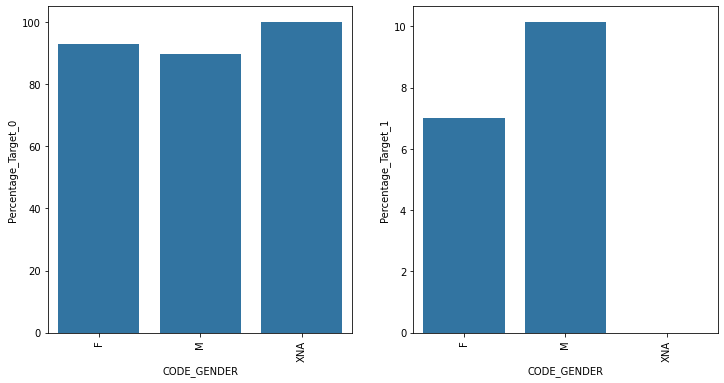

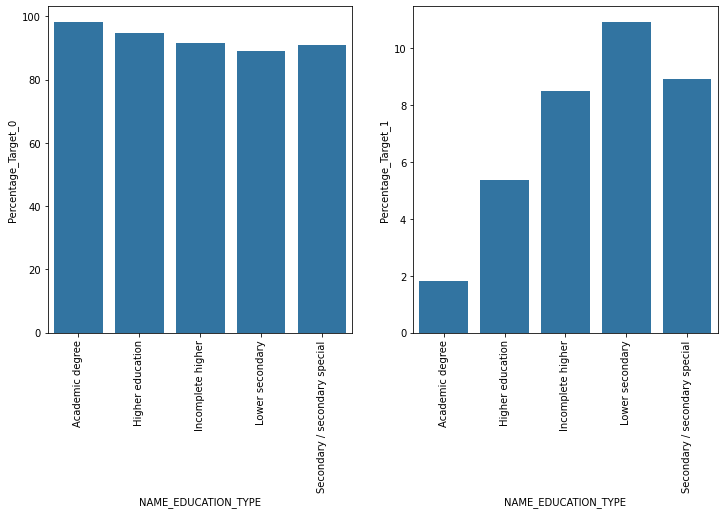

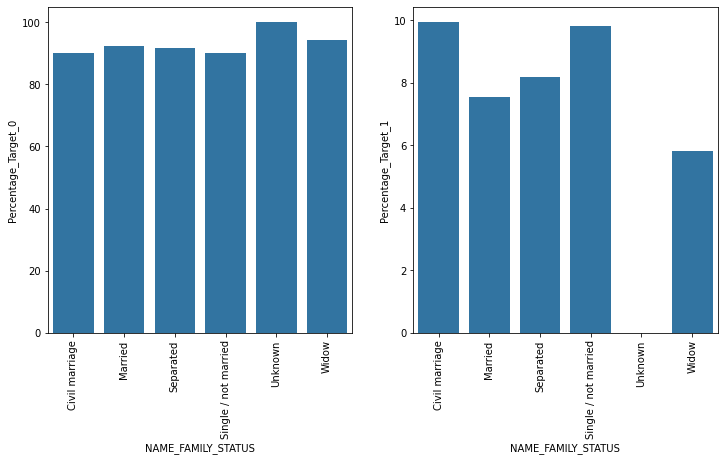

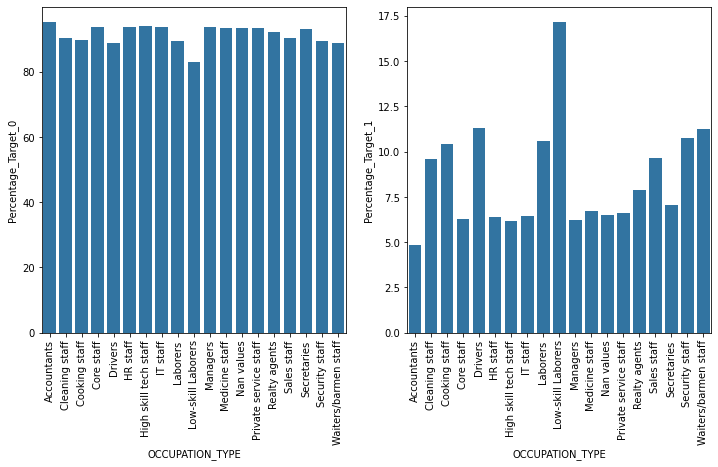

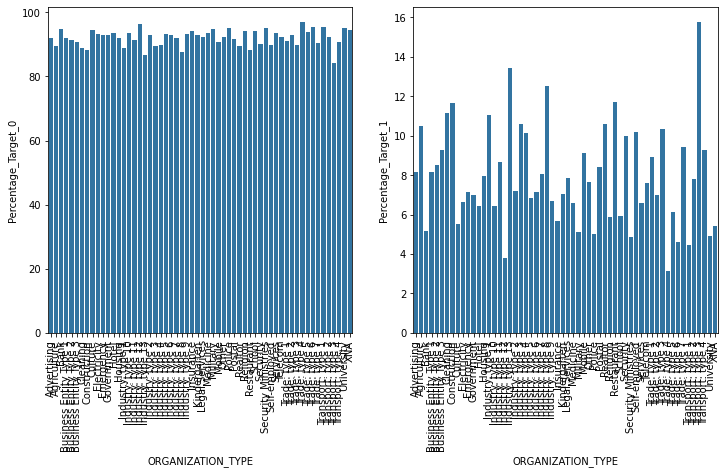

In [20]:
cat_stats(application_train,important_features)


for the first question, it seems that women are less defaulted than men and they are more repayable than men.So as a recommandation to the bank is to improve the procedure of repayment of loans given to men.

for the second question, poeple with a low education level shows the most defaulters ,in the first place people with less than secondary school. Also people with a hight education level are less prone to default. This feature show a significative difference of the distributions of defaulter and non defaulter so it will be helpfull for the modeling task.

for the third question, widow category are the least defaulder and the civil marriage category are the most defaulter category ,and this can be explained with the high amout of expences for families so they maight face problems in paying their annuity.

for the forth question ,the most likely category that defaults is the low labores and the less category to default is accountant ,this is very logic .Another finding from this plot is that the all categories have uniform destribution in the non defaulter set .

In [21]:
# Perform chi-squared test
def chi2_test(df):
    chi2_stat_list=[]; p_val_list=[]; dof_list=[]; ex_list=[]
    for var in df.columns:
        chi2_stat, p_val, dof, ex = stats.chi2_contingency(pd.crosstab(application_train['TARGET'], application_train[var]))
        chi2_stat_list.append(chi2_stat); p_val_list.append(p_val); dof_list.append(dof); ex_list.append(ex);
    chi_squared=pd.DataFrame({'variable':df.columns,'dof':dof_list,'chi2_stat':chi2_stat_list,'p_val':p_val_list})
    chi_squared.set_index('variable',inplace=True)
    print(chi_squared.sort_values(by='p_val',ascending=True))

In [22]:
chi2_test(application_train.select_dtypes('O'))


                            dof    chi2_stat          p_val
variable                                                   
OCCUPATION_TYPE              18  1975.082752   0.000000e+00
ORGANIZATION_TYPE            57  1609.240636  5.224541e-299
NAME_INCOME_TYPE              7  1253.470808  1.928146e-266
NAME_EDUCATION_TYPE           4  1019.213187  2.447681e-219
CODE_GENDER                   2   920.791334  1.129022e-200
WALLSMATERIAL_MODE            7   599.041379  3.916842e-125
EMERGENCYSTATE_MODE           2   547.975997  1.019821e-119
HOUSETYPE_MODE                3   509.405086  4.369310e-110
NAME_FAMILY_STATUS            5   504.694083  7.744842e-107
NAME_HOUSING_TYPE             5   420.556190   1.099089e-88
NAME_CONTRACT_TYPE            1   293.150542   1.023515e-65
FONDKAPREMONT_MODE            4   281.716375   9.504317e-60
FLAG_OWN_CAR                  1   146.656018   9.330994e-34
NAME_TYPE_SUITE               7    45.190054   1.256203e-07
FLAG_OWN_REALTY               1    11.57

the features that we assumed to be important are the same the most significative one .This garante our approach and strategy.

More than inatial ones ,features such as NAME_HOUSING_TYPE, FLAG_OWN_CAR , NAME_CONTRACT_TYPE tends to be significatif and helpful.

In [23]:
application_train.drop(['SK_ID_CURR','CREATED_BY','CREATED_AT'],inplace=True,axis=1)
SK_ID_CURR=application_test['SK_ID_CURR']
application_test.drop(['SK_ID_CURR','CREATED_BY','CREATED_AT'],inplace=True,axis=1)
application_train['DAYS_EMPLOYED'].replace(365243,np.nan,inplace=True)
application_test['DAYS_EMPLOYED'].replace(365243,np.nan,inplace=True)
application_train['CODE_GENDER'].replace('XNA',np.nan,inplace=True)
application_test['CODE_GENDER'].replace('XNA',np.nan,inplace=True)

Aggregating the 20 flag document features into a single feature by summing the number of flag documents per applicant can be a useful approach. By creating a new aggregated feature, we can capture the overall count or presence of flag documents for each applicant and reduce sparsity of the data, which may provide valuable information for the analysis or modeling task.

In [24]:
FLAG_DOCUMENT=['FLAG_DOCUMENT_2',
'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5',
'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8',
'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11',
'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14',
'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17',
'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
'FLAG_DOCUMENT_21']
application_train['FLAG_DOCUMENT']=application_train[FLAG_DOCUMENT].sum(axis=1)
application_test['FLAG_DOCUMENT']=application_test[FLAG_DOCUMENT].sum(axis=1)
application_train.drop(FLAG_DOCUMENT,axis=1,inplace=True)
application_test.drop(FLAG_DOCUMENT,axis=1,inplace=True)

we should drop the AMT_REQ_CREDIT features because of they have no impact to the target and this may cause model missleading.

In [25]:
AMT_REQ_CREDIT=['AMT_REQ_CREDIT_BUREAU_HOUR','AMT_REQ_CREDIT_BUREAU_DAY',
                'AMT_REQ_CREDIT_BUREAU_WEEK','AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT']
application_train.drop(AMT_REQ_CREDIT,axis=1,inplace=True)
application_test.drop(AMT_REQ_CREDIT,axis=1,inplace=True)

Two new features, AGE and YEARS_EMPLOYED, were created to provide additional information about the applicants' age and years of employment, respectively.
also DEBT_TO_INCOME_RATIO: This feature calculates the debt-to-income ratio by dividing the applicant's total credit amount by their total income.

In [26]:
# Age Feature
application_train['AGE']=application_train['DAYS_BIRTH']/(-365)
application_test['AGE']=application_test['DAYS_BIRTH']/(-365)
# MEAN_EXT_SOURCE
application_train['MEAN_EXT_SOURCE'] = application_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
application_test['MEAN_EXT_SOURCE'] = application_test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
# Generate YEARS_EMPLOYED
application_train['YEARS_EMPLOYED']=application_train['DAYS_EMPLOYED']/(-365)
application_test['YEARS_EMPLOYED']=application_test['DAYS_EMPLOYED']/(-365)
# DAYS_BIRTH_SQUARED
application_train['DAYS_BIRTH_SQUARED'] = application_train['DAYS_BIRTH'] ** 2
application_test['DAYS_BIRTH_SQUARED'] = application_test['DAYS_BIRTH'] ** 2
# Generate DEBT_TO_INCOME_RATIO 
application_train['DEBT_TO_INCOME_RATIO'] = application_train['AMT_CREDIT'] / application_train['AMT_INCOME_TOTAL']
application_test['DEBT_TO_INCOME_RATIO'] = application_test['AMT_CREDIT'] / application_test['AMT_INCOME_TOTAL']
# Generate INCOME_TO_CREDIT 
application_train['INCOME_TO_CREDIT'] = application_train['AMT_INCOME_TOTAL'] / application_train['AMT_CREDIT']
application_test['INCOME_TO_CREDIT'] = application_test['AMT_INCOME_TOTAL'] / application_test['AMT_CREDIT']


In [27]:
new_numeric_features=['AGE','YEARS_EMPLOYED','DEBT_TO_INCOME_RATIO','INCOME_TO_CREDIT','DAYS_BIRTH_SQUARED']

In [28]:
t_test(application_train[new_numeric_features])

,variable,t_stat,p_val
0,AGE,43.519836,0.000000
1,DEBT_TO_INCOME_RATIO,4.284907,0.000018


additional feature engineering was performed on both datasets. The following features were created based on patterns and analysis from EDA phase :

_INCOME_CLASS: This feature categorizes the AMT_INCOME_TOTAL into three income classes: 'Low_INCOME', 'Medium_INCOME', and 'High_INCOME'.

ANNUITY_CLASS: This feature divides the AMT_ANNUITY into three annuity classes: 'Low_ANNUITY', 'Medium_ANNUITY', and 'High_ANNUITY'.

AMT_GOODS_PRICE_0.2_0.7: This binary feature indicates whether the AMT_GOODS_PRICE falls within the range of 20000 and 70000.

DAYS_BIRTH_CLASS: This binary feature flags applicants with a DAYS_BIRTH value less than -15000, indicating older individuals.

CREDIT_UNDER_100K: This binary feature identifies applicants with an AMT_CREDIT value below 100,000.

YEARS_EMPLOYED_CLASS: This binary feature categorizes applicants based on their DAYS_EMPLOYED value, considering values less than 100,000.

In [29]:
application_train['_INCOME_CLASS']=pd.qcut(application_train['AMT_INCOME_TOTAL'],3,labels=['Low_INCOME', 'Medium_INCOME', 'High_INCOME'])
application_train['ANNUITY_CLASS']=pd.qcut(application_train['AMT_ANNUITY'],3,labels=['Low_ANNUITY', 'Medium_ANNUITY', 'High_ANNUITY'])
application_train['AMT_GOODS_PRICE_0.2_0.7']=np.where((application_train['AMT_GOODS_PRICE']<= 70000) & (application_train['AMT_GOODS_PRICE']>=20000) ,1,0)
application_train['DAYS_BIRTH_CLASS']=np.where(application_train['DAYS_BIRTH']<-15000,1,0)
application_train['CREDIT_UNDER_100K']=np.where(application_train['AMT_CREDIT']<100000,1,0)
application_train['YEARS_EMPLOYED_CLASS']=np.where(application_train['DAYS_EMPLOYED']<100000,1,0)

application_test['_INCOME_CLASS']=pd.qcut(application_test['AMT_INCOME_TOTAL'],3,labels=['Low_INCOME', 'Medium_INCOME', 'High_INCOME'])
application_test['ANNUITY_CLASS']=pd.qcut(application_test['AMT_ANNUITY'],3,labels=['Low_ANNUITY', 'Medium_ANNUITY', 'High_ANNUITY'])
application_test['AMT_GOODS_PRICE_0.2_0.7']=np.where((application_test['AMT_GOODS_PRICE']<= 7000) & (application_test['AMT_GOODS_PRICE']>=2000) ,1,0)
application_test['DAYS_BIRTH_CLASS']=np.where(application_test['DAYS_BIRTH']<-15000,1,0)
application_test['CREDIT_UNDER_100K']=np.where(application_test['AMT_CREDIT']<100000,1,0)
application_test['YEARS_EMPLOYED_CLASS']=np.where(application_test['DAYS_EMPLOYED']<100000,1,0)

In [30]:
new_categorical_features = ['_INCOME_CLASS','YEARS_EMPLOYED_CLASS','ANNUITY_CLASS',
                            'AMT_GOODS_PRICE_0.2_0.7','DAYS_BIRTH_CLASS','CREDIT_UNDER_100K']

Let's test the statistical significance of the relationship between the new categorical features and the target variable, providing insights into their potential importance in predicting the target variable of interest

In [31]:
chi2_test(application_train[new_categorical_features])

                         dof    chi2_stat          p_val
variable                                                
DAYS_BIRTH_CLASS           1  1344.950176  1.927723e-294
YEARS_EMPLOYED_CLASS       1   649.888509  2.362427e-143
ANNUITY_CLASS              2   157.760399   5.530502e-35
_INCOME_CLASS              2   152.501899   7.667140e-34
CREDIT_UNDER_100K          1    53.721017   2.310781e-13
AMT_GOODS_PRICE_0.2_0.7    1    34.102392   5.228696e-09


Based on the chi-squared test conducted on the new categorical features, the results indicate that several of these features exhibit a significant association with the target variable. The DAYS_BIRTH_CLASS, ANNUITY_CLASS, _INCOME_CLASS,AMT_GOODS_PRICE_0.2_0.7 and CREDIT_UNDER_100K features show statistically significant relationships with the target variable, as evidenced by their low p-values. This suggests that these features may be informative in predicting the target variable and can potentially be valuable in the modeling process.

In [32]:
# Detect highly missing numeric features 
application_train_numeric= application_train.select_dtypes(include=['number'])
missings=application_train_numeric.loc[:,application_train_numeric.isna().mean() >= 0.6]
highly_missing_features = missings.columns
missings.columns

Index(['OWN_CAR_AGE', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'FLOORSMIN_AVG',
       'LIVINGAPARTMENTS_AVG', 'NONLIVINGAPARTMENTS_AVG', 'YEARS_BUILD_MODE',
       'COMMONAREA_MODE', 'FLOORSMIN_MODE', 'LIVINGAPARTMENTS_MODE',
       'NONLIVINGAPARTMENTS_MODE', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI',
       'FLOORSMIN_MEDI', 'LIVINGAPARTMENTS_MEDI', 'NONLIVINGAPARTMENTS_MEDI'],
      dtype='object')

In [33]:
#Remove highly missing features
application_train.drop(highly_missing_features,axis=1,inplace=True)
application_test.drop(highly_missing_features,axis=1,inplace=True)

In [34]:
target = application_train['TARGET']
features_train = application_train.drop('TARGET', axis=1)

# Impute numerical features using mean imputation
numeric_imputer = SimpleImputer(strategy='median')
numeric_features_train = features_train.select_dtypes(include='number')
imputed_numeric_features_train = numeric_imputer.fit_transform(numeric_features_train)
numeric_features_test = application_test.select_dtypes(include='number')
imputed_numeric_features_test = numeric_imputer.transform(numeric_features_test)

In [35]:
categorical_features_train = features_train.select_dtypes(include='object')
# using dummy_na=False ,we perform onehot encoding without affecting data distribution
dummy_categorical_features_train = pd.get_dummies(categorical_features_train,dummy_na=False)

# Concatenate imputed numerical and categorical features Train
imputed_features_train = pd.concat([pd.DataFrame(imputed_numeric_features_train, columns=numeric_features_train.columns),
                              dummy_categorical_features_train] ,axis=1)

# Impute categorical features Test using mode imputation and one-hot encoding

categorical_features_test = application_test.select_dtypes(include='object')
dummy_categorical_features_test = pd.get_dummies(categorical_features_test,dummy_na=False)

# Concatenate imputed numerical and categorical features
imputed_features_test = pd.concat([pd.DataFrame(imputed_numeric_features_test, columns=numeric_features_test.columns),
                              dummy_categorical_features_test],
                             axis=1)


In [36]:
imputed_features_train.drop('NAME_INCOME_TYPE_Maternity leave',axis=1,inplace=True)
imputed_features_train.drop('NAME_FAMILY_STATUS_Unknown',axis=1,inplace=True)

In [37]:
X=imputed_features_train.copy()
y=target
#splitting data to train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y, test_size=0.25, random_state=27)

In [38]:
# Define class weights
class_weights = {0: 1, 1: 9}

simple_estimators = {'Logistic Regression':LogisticRegression(),
                     'Decision Tree':DecisionTreeClassifier(),
                     'Linear Discriminant Analysys': LinearDiscriminantAnalysis()}

In [41]:
def training_simple_models(estimators):
    for name, model in estimators.items():
        print("Running " + name)

        # Apply SMOTE oversampling to the training data
        #smote = SMOTE()
        #X_train_smt, y_train_smt = smote.fit_resample(X_train, y_train)
        X_train_smt, y_train_smt = X_train, y_train
        # Scaling data
        scaler = MinMaxScaler()
        X_train_scaled= scaler.fit_transform(X_train_smt)
        X_test_scaled=scaler.transform(X_test)
        
        # Perform Recursive Feature Elimination (RFE)
        selector = RFE(estimator=model)
        X_train_selected = selector.fit_transform(X_train_scaled, y_train_smt)
        X_test_selected = selector.transform(X_test_scaled)
        
        # Train the model on the selected features
        model.fit(X_train_selected, y_train_smt)
        
        # Make predictions on the test data
        y_pred = model.predict_proba(X_test_selected)[:, 1]
        
        # Calculate and print the ROC AUC score
        roc_auc = roc_auc_score(y_test, y_pred)
        print("roc_auc:", roc_auc)
        print('*' * 20)

In [ ]:
training_simple_models(simple_estimators)

Running Logistic Regression


In [ ]:
# Create an instance of the GradientBoostingClassifier class
clf = GradientBoostingClassifier(n_estimators=100, subsample=0.2, random_state=42, verbose = 1)

# Fit the model to the training data
clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clf.predict_proba(X_test)[:,1]
roc_GBC=roc_auc_score(y_test,y_pred)
print(roc_GBC)

In [ ]:
# Running Xgboost
# Define class weights
class_weights = {0: 1, 1: 9}

# Create an instance of the XGBClassifier class
xgb = XGBClassifier(n_estimators=100, subsample=0.4, random_state=1, scale_pos_weight=class_weights[1]/class_weights[0])

# Fit the model to the training data
xgb.fit(X_train, y_train)

# Make predictions on the test data
y_pred = xgb.predict_proba(X_test)[:,1]
roc_xgb=roc_auc_score(y_test,y_pred)
print(roc_xgb)

In [ ]:
# Running Random Forest 
rfc_100 = RandomForestClassifier(n_estimators=100, random_state=0)
rfc_100.fit(X_train, y_train)
y_pred_100 = rfc_100.predict_proba(X_test)[:,1]
print('Model auc score with 100 decision-trees : {0:0.4f}'. format(roc_auc_score(y_test, y_pred_100)))

In [ ]:
# Tuning Gradient Boosting Classifier

param_dist = {
    'n_estimators': [50, 100, 200, 400],
    'max_depth': [10, 20, 30, 40, 50, 60],
    'min_samples_split': [5,10, 20, 30],
    'min_samples_leaf':[10, 20, 30, 40, 50, 60],
    'max_features': ['sqrt', 'log2', None],
    'subsample': [0.8, 0.9, 1.0],
    'learning_rate': [0.1, 0.01, 0.001]
}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
gbc = RandomizedSearchCV(GradientBoostingClassifier(),
                            param_distributions=param_dist,
                            n_iter=10,
                            cv=cv,
                            scoring='roc_auc',
                            random_state=1,
                            verbose=True,
                            n_jobs=cpu_count())

# Handle class imbalance by setting sample weights
sample_weights = [1 if label == 0 else 9 for label in y_train]

gbc.fit(X_train, y_train, sample_weight=sample_weights)

In [ ]:
best_gbc
print("Best parameter (CV score=%0.3f):" % gbc.best_score_)
print(gbc.best_params_)

In [ ]:
def roc_curve__confusion_matrix(model):
    from sklearn.metrics import roc_curve, auc
    y_prob_test = model.predict_proba(X_test)[:, 1]
    y_prob_train  = model.predict_proba(X_train)[:, 1]
    prediction=model.predict(X_test)
    # calculate tpr ,fpr
    fpr_test , tpr_test , thresholds = roc_curve(y_test, y_prob_test)
    fpr_train , tpr_train , thresholds1 = roc_curve(y_train, y_prob_train)

    # calculate AUC score
    roc_auc_test  = auc(fpr_test, tpr_test)
    roc_auc_train  = auc(fpr_train ,tpr_train)


    # calculate confusion matrix for test set
    confusion_matrix_test = confusion_matrix(y_test, prediction)

    # create subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # plot ROC curves on the first subplot
    axs[0].plot(fpr_train, tpr_train, color='green', label='ROC curve train (AUC = %0.2f)' % roc_auc_train)
    axs[0].plot(fpr_test, tpr_test, color='blue', label='ROC curve test (AUC = %0.2f)' % roc_auc_test)
    axs[0].plot([0, 1], [0, 1], color='red', linestyle='--')
    axs[0].set_xlabel('False Positive Rate')
    axs[0].set_ylabel('True Positive Rate')
    axs[0].set_title('Receiver Operating Characteristic (ROC) Curve')
    axs[0].legend(loc="lower right")

    sns.set(font_scale=1.4)
    sns.heatmap(confusion_matrix_test, annot=True, fmt='g', cmap='Blues', ax=axs[1])
    axs[1].set_xlabel('Predicted label')
    axs[1].set_ylabel('True label')
    axs[1].set_title('Confusion Matrix (Test Set)model');

    plt.tight_layout()
    plt.show()

In [ ]:
roc_curve__confusion_matrix(best_LR)

In [ ]:
roc_curve__confusion_matrix(best_gbc)

In [ ]:
def feature_importance(model):  
    
    # Extract features importance from model
    importances = model.feature_importances_
    sorted_idx = importances.argsort()[::-1]
    feature_scores = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)
    important_features=feature_scores[:10]
    
    # Creating a seaborn bar plot for features importance
    f, ax = plt.subplots(figsize=(30, 24))
    ax = sns.barplot(x=feature_scores, y=feature_scores.index, data=feature_scores)
    ax.set_title("Visualize feature scores of the features")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set_yticklabels(feature_scores.index)
    ax.set_xlabel("Feature importance score")
    ax.set_ylabel("Features")
    plt.show()
    print(important_features)

In [ ]:
feature_importance(best_gbc)

In [ ]:
# Make a submission for Logistic Regression
submit = application_test[['SK_ID_CURR']]
submit['TARGET'] = best_LR.predict_proba(imputed_features_test)[:,1]
submit.to_csv('submission_LR.csv', index = False)